In [1]:
import numpy as np
from scipy.signal import butter, filtfilt
import pickle

from basicOperations.manifoldOperations import tSNEmbedding

In [2]:
"Figure 8."

'Figure 8.'

In [3]:
from matplotlib import font_manager
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

fontPath = '/usr/share/fonts/truetype/msttcorefonts/Times_New_Roman_Italic.ttf'
fontProp = font_manager.FontProperties(fname = fontPath)

font_manager.fontManager.addfont(fontPath)
mpl.rcParams['font.family'] = fontProp.get_name()

In [4]:
numberChannels = 12
numberGestures = 10
trialsPerGesture = 36

In [5]:
subjectNumber = 80

In [6]:
name = "../formattedData/" + str(subjectNumber) + ".pkl"

with open(name, "rb") as file:
    loadedData = pickle.load(file)

In [7]:
Features = loadedData["EMG"]
normalizedFeatures = Features
Labels = loadedData["Labels"]

Indices =  {0: [], 1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7: [], 8: [], 9: []}
for i in range(len(Labels)):
    Indices[Labels[i]].append(i)

gesturesLabels = np.zeros((numberGestures, trialsPerGesture, numberChannels, 4000))
for i in range(numberGestures):
    for j in range(trialsPerGesture):
        gesturesLabels[i, j] = normalizedFeatures[Indices[i][j], :, :4000]

In [8]:
def butterworthBandpass(lowcut, highcut, fs, order = 3):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype = 'band')
    return b, a

def applyBandpassFilter(data, lowcut, highcut, fs, order = 3):
    b, a = butterworthBandpass(lowcut, highcut, fs, order = order)
    filteredData = filtfilt(b, a, data, axis = -1)
    return filteredData

In [9]:
frequencies = np.array([[20, 50], [50, 110], [110, 230], [230, 450]])
filteredData = np.zeros((4, numberGestures, trialsPerGesture, numberChannels, 4000))
for i in range(len(frequencies)):
    filteredData[i] = applyBandpassFilter(gesturesLabels, frequencies[i, 0], frequencies[i, 1], 2000)

In [10]:
mean = np.mean(filteredData, axis = -1)
std = np.std(filteredData, axis = -1)
normalizedFilteredData = (filteredData - mean[..., np.newaxis])/std[..., np.newaxis]

In [11]:
covarianceMatrices = np.zeros((4, numberGestures, trialsPerGesture, numberChannels, numberChannels))

In [12]:
for f in range(4):
    for gesture in range(numberGestures):
        for repitition in range(trialsPerGesture):
            covarianceMatrices[f, gesture, repitition] = 1/4000 * (normalizedFilteredData[f, gesture, repitition, :, :4000] @ np.transpose(normalizedFilteredData[f, gesture, repitition, :, :4000]))

In [13]:
LABELS = np.array([[0] * 36, [1] * 36, [2] * 36, [3] * 36, [4] * 36, [5] * 36, [6] * 36, [7] * 36, [8] * 36, [9] * 36])
LABELS = LABELS.reshape(-1)
print(LABELS.shape)

(360,)


In [14]:
tSNE = tSNEmbedding()

In [15]:
out = np.zeros((4, 360, 2))
for i in range(4):
    out[i] = tSNE.tSNE(covarianceMatrices[i], 20, numberChannels)

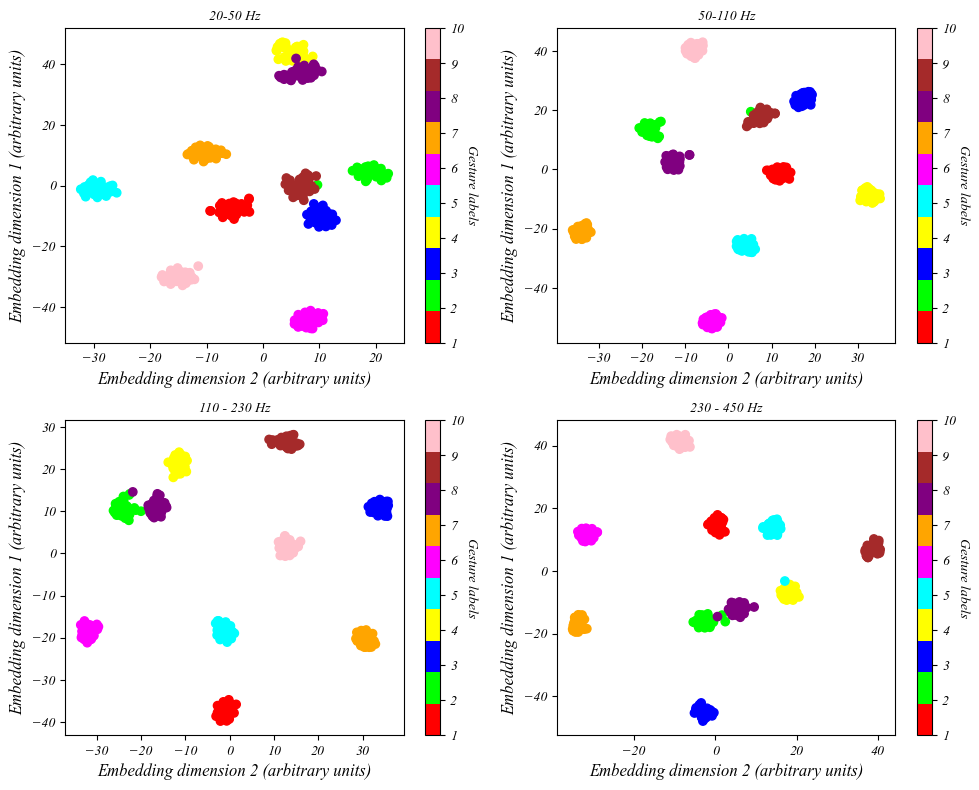

In [16]:
colors = ['#FF0000', '#00FF00', '#0000FF', '#FFFF00', '#00FFFF', '#FF00FF', '#FFA500', '#800080', '#A52A2A', '#FFC0CB']
colors = ListedColormap(colors)

fig, axs = plt.subplots(2, 2, figsize = (10, 8))
title = ["20-50 Hz", "50-110 Hz", "110 - 230 Hz", "230 - 450 Hz"]

def plot_scatter(ax, freq):
    scatter = ax.scatter(out[freq, :, 0], out[freq, :, 1], c = LABELS, cmap = colors)
    ax.set_xlabel('Embedding dimension 2 (arbitrary units)', fontproperties = fontProp, fontsize = 12)
    ax.set_ylabel('Embedding dimension 1 (arbitrary units)', fontproperties = fontProp, fontsize = 12)
    ax.set_title(title[freq], fontproperties = fontProp)
    numCategories = len(set(LABELS))
    cb = fig.colorbar(scatter, ax = ax)
    cb.set_ticks(range(numCategories))
    cb.set_ticklabels([format(i + 1) for i in range(numCategories)])
    cb.set_label('Gesture labels', rotation = 270, labelpad = 10)

radix = 0
for i in range(2):
    for j in range(2):
        plot_scatter(axs[i, j], radix)
        radix += 1

plt.tight_layout()

plt.savefig("tSNEMatricesFrequencies.eps", format = "eps", bbox_inches = 'tight')
plt.show()
plt.close()